<a href="https://colab.research.google.com/github/Mariam-Nazlawy/Image-Compression/blob/main/Eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries

In [1]:
import numpy as np
from numpy.linalg import eig
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Data

## Load the dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)

n_samples, h, w = lfw_people.images.shape


X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("Image Shape: %d" % h, w)

Total dataset size:
n_samples: 1288
n_features: 2914
n_classes: 7
Image Shape: 62 47


## X shape

In [3]:
X.shape

(1288, 2914)

In [4]:
print(X)

[[0.9973857  0.9973857  0.99607843 ... 0.38431373 0.3869281  0.3803922 ]
 [0.14509805 0.1633987  0.21437909 ... 0.44575164 0.4509804  0.58300656]
 [0.34379086 0.3503268  0.4366013  ... 0.7163399  0.7202614  0.7176471 ]
 ...
 [0.35947713 0.34901962 0.32026145 ... 0.21699347 0.21568628 0.17777778]
 [0.19346406 0.21176471 0.2901961  ... 0.6862745  0.654902   0.5908497 ]
 [0.12287582 0.09803922 0.10980392 ... 0.12941177 0.1633987  0.29150328]]


## Plot samples from the data

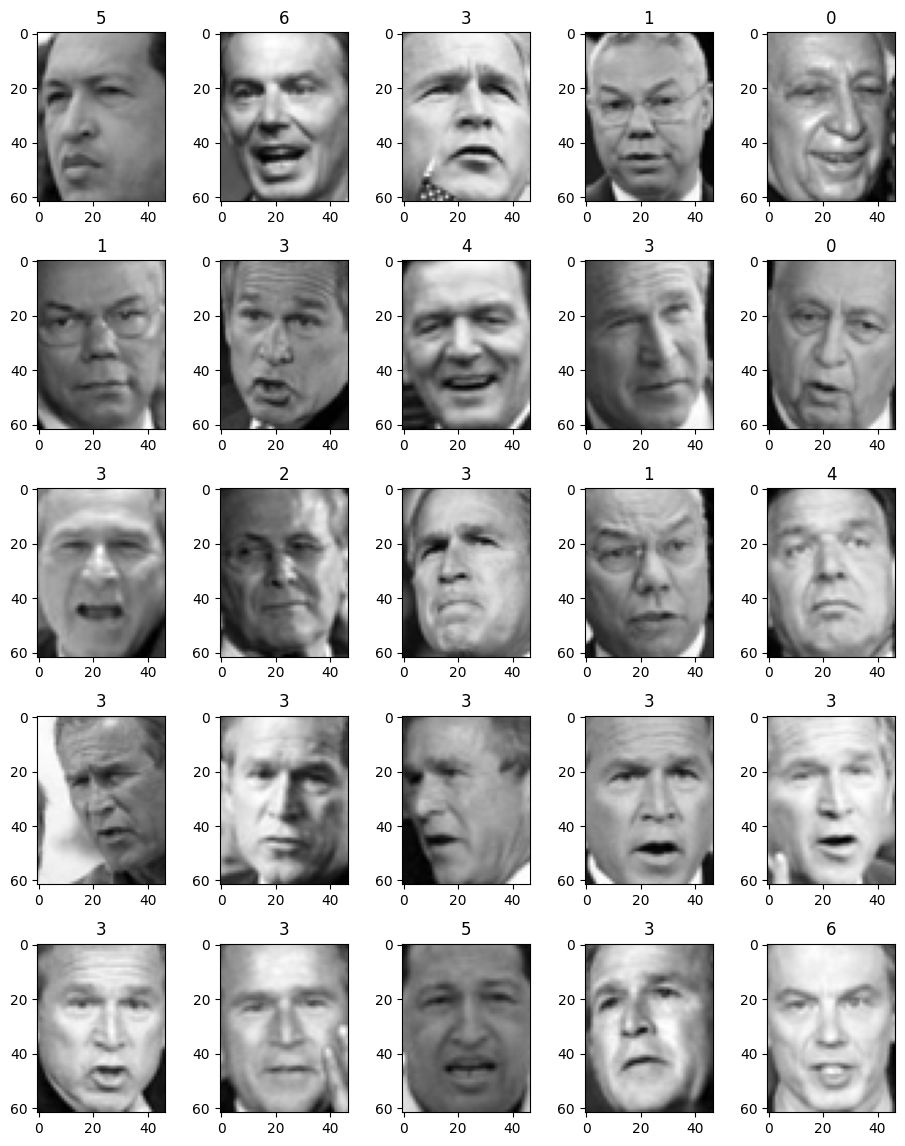

In [5]:
n_row=5
n_col=5

plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(lfw_people.images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(lfw_people.target[i], size=12)

# PCA

In [6]:
class PCA:
  def __init__(self, num_components):
    self.num_components = num_components
    self.mean_face = np.ndarray([])
    self.eigenfaces = np.ndarray([])

  def center(self, imgs):
    self.mean_face = np.mean(imgs, axis=0).real
    centered_imgs = imgs - self.mean_face
    return centered_imgs.real

  def cals_covariance(self, imgs):
    covariance_matrix = np.cov(imgs.T, rowvar=True)
    return covariance_matrix.real

  def calc_eigenfaces(self, covariance_matrix):
    eigenvalues, eigenfaces = eig(covariance_matrix)
    self.eigenfaces = self.select_eigenfaces(eigenvalues, eigenfaces)

  def select_eigenfaces(self, eigenvalues, eigenfaces):
      sorted_indices = np.argsort(eigenvalues)[::-1]
      eigenfaces = eigenfaces[:, sorted_indices]

      selected_eigenfaces = eigenfaces[:, :self.num_components]

      return selected_eigenfaces.real

  def projection(self, centered_imgs):
      return np.dot(centered_imgs, self.eigenfaces).real

  def compress(self, imgs):
    centered_imgs = self.center(imgs)
    covariance_matrix = self.cals_covariance(centered_imgs)
    self.calc_eigenfaces(covariance_matrix)
    compressed_imgs = self.projection(centered_imgs)

    return compressed_imgs.real

  def reconstruct(self, compressed_imgs, imgs):
    reconstructed_imgs = (np.dot(compressed_imgs, self.eigenfaces.T) + self.mean_face).real
    reconstructed_imgs = reconstructed_imgs.reshape(imgs.shape)
    return reconstructed_imgs

## Create the object with the required number of components

In [7]:
pca = PCA(744)

## Compress the images

In [8]:
compressed_imgs = pca.compress(X)

## Decompress the images

In [9]:
reconstructed_imgs = pca.reconstruct(compressed_imgs, X)

## Plot compressed images

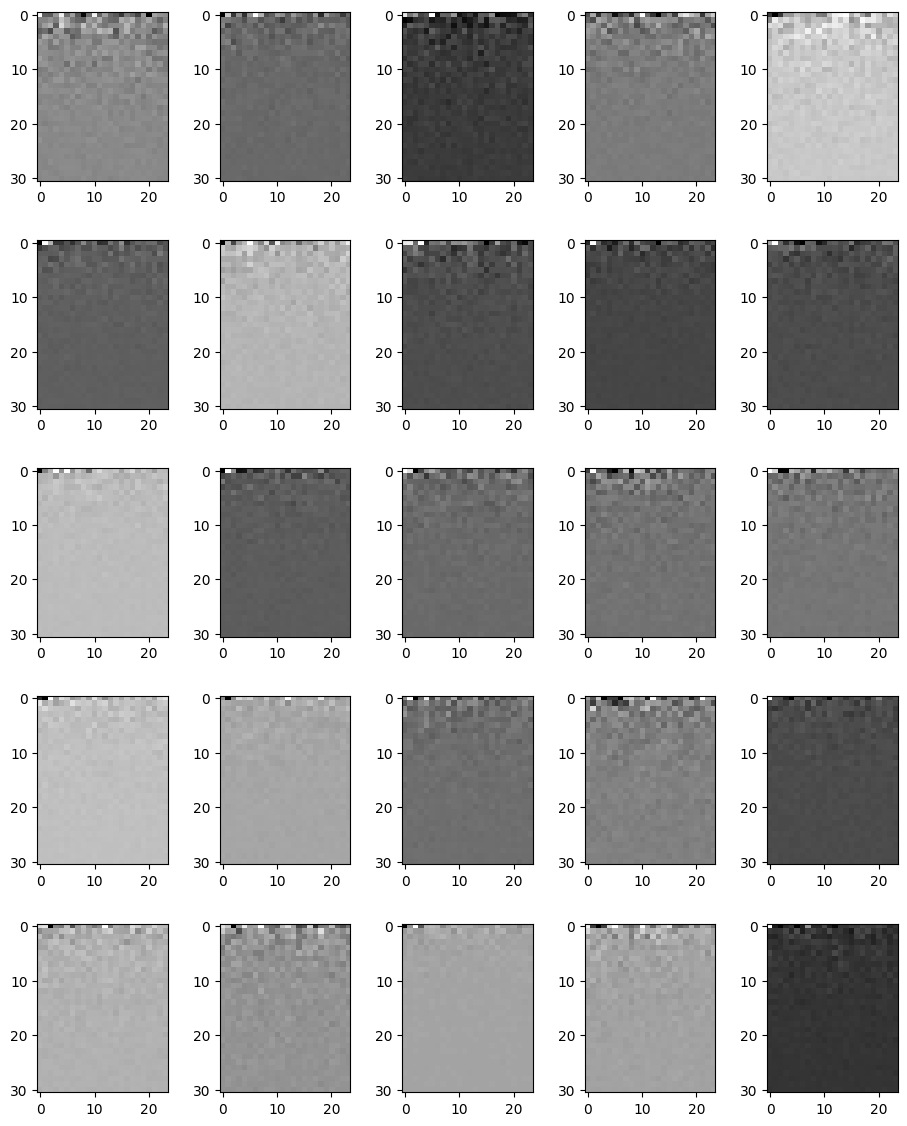

In [10]:
n_row=5
n_col=5

plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(compressed_imgs[i].reshape((31, 24)), cmap=plt.cm.gray)

## Plot decompressed images

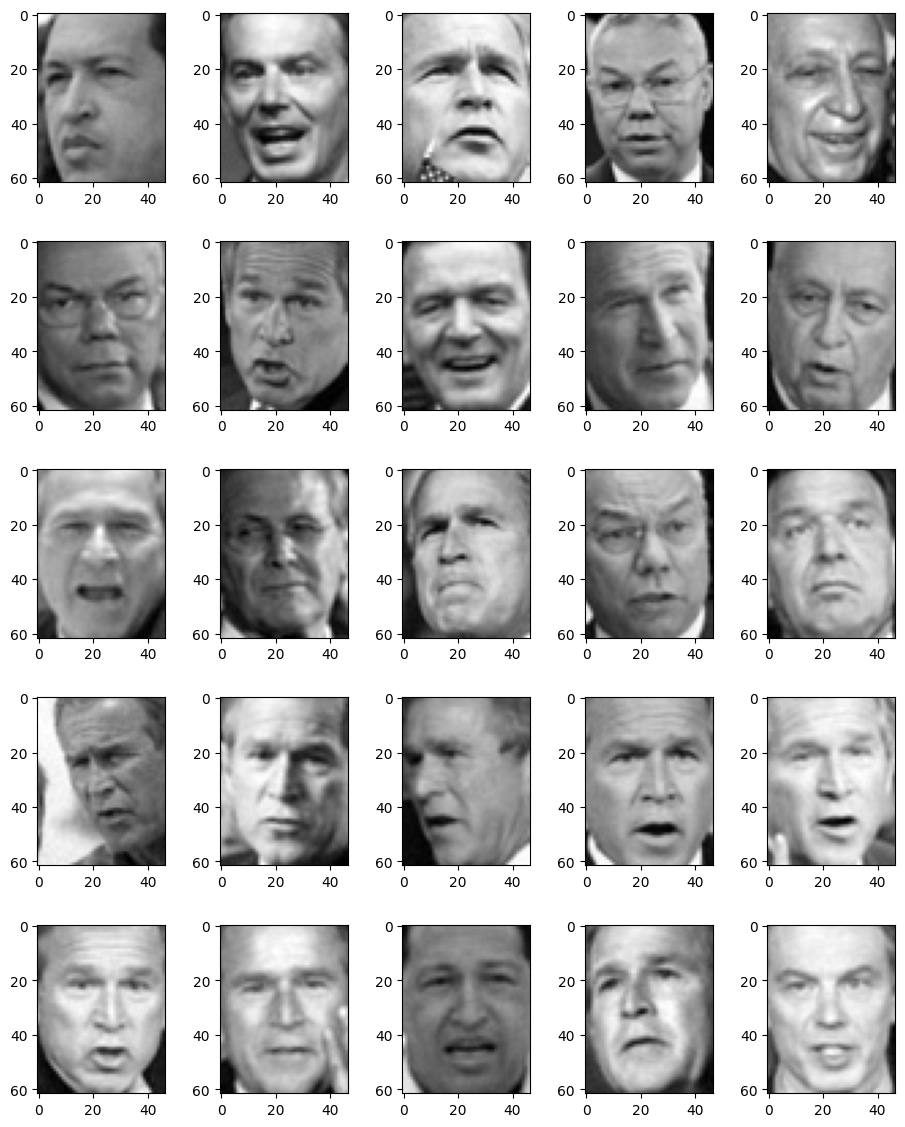

In [11]:
n_row=5
n_col=5

plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(reconstructed_imgs[i].reshape((h, w)), cmap=plt.cm.gray)

## Plot mean face

### For Original Images

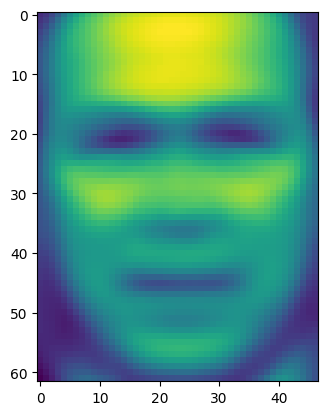

In [12]:
plt.imshow(pca.mean_face.reshape((h, w)))
plt.show()

### For Decompressed Images

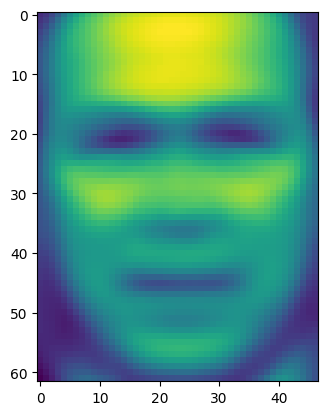

In [13]:
mean_face_decompressed = np.mean(reconstructed_imgs, axis=0).real
plt.imshow(pca.mean_face.reshape((h, w)))
plt.show()

## Shapes of compressed and decompressed images

In [14]:
print(reconstructed_imgs.shape)
print(compressed_imgs.shape)

(1288, 2914)
(1288, 744)


# Face Recognition Clf

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [16]:
pca_train = PCA(744)
pca_test = PCA(744)
pca_train_compress = pca_train.compress(X_train)
pca_test_compress = pca_test.compress(X_test)

In [17]:
clf = SVC()

In [18]:
clf.fit(pca_train_compress, y_train)

SVC()

In [19]:
y_pred = clf.predict(pca_test_compress)

In [20]:
accuracy_score(y_test, y_pred)

0.3385093167701863

In [21]:
clf2 = SVC()

In [22]:
clf.fit(X_train, y_train)

SVC()

In [23]:
y_pred2 = clf.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred2)

0.7236024844720497

In [25]:
pca = PCA(744)
pca_train_compress = pca.compress(X_train)
pca_test_compress = pca.compress(X_test)

In [26]:
clf = SVC()

In [27]:
clf.fit(pca_train_compress, y_train)

SVC()

In [28]:
y_pred = clf.predict(pca_test_compress)

In [29]:
accuracy_score(y_test, y_pred)

0.3385093167701863

In [30]:
clf2 = SVC()

In [31]:
clf.fit(X_train, y_train)

SVC()

In [32]:
y_pred2 = clf.predict(X_test)

In [33]:
accuracy_score(y_test, y_pred2)

0.7236024844720497